In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
SCORE_DIR = './curv_scores'

In [3]:
def load_scores_for_dir(dir_path, num_runs=10):
    score_dict = dict()
    for i in range(10):
        run_dict = np.load(f'{dir_path}/run_{i+1}.npz')
        score_dict[i+1] = run_dict['scores']
    return pd.DataFrame(score_dict)

def load_subset_scores_for_dir(dir_path, num_runs=10):
    total_dict = dict()
    for i in range(10):
        run_dict = np.load(f'{dir_path}/run_{i+1}.npz')
        subset, scores = run_dict['subset'], run_dict['scores']
        total_dict[f'idxs {i+1}'] = subset
        total_dict[f'scores {i+1}'] = scores[subset]
    return pd.DataFrame(total_dict)

In [4]:
def get_subsets_from_path(dir_path, num_runs=10):
    subset_dict = dict()
    for i in range(10):
        run_dict = np.load(f'{dir_path}/run_{i+1}.npz')
        subset = run_dict['subset']
        subset_dict[i+1] = subset
    return subset_dict

def get_scores_from_path(dir_path, num_runs=10):
    score_dict = dict()
    for i in range(10):
        run_dict = np.load(f'{dir_path}/run_{i+1}.npz')
        scores = run_dict['scores']
        score_dict[i+1] = scores
    return scores

In [5]:
def get_averages_from_run(dir_path, num_runs=10):
    score_dict = load_scores_for_dir(dir_path, num_runs=num_runs)
    return np.array([np.mean(score_dict[i+1]) for i in range(num_runs)])

def get_averages_from_subsets(dir_path, num_runs=10):
    subset_df = load_subset_scores_for_dir(dir_path, num_runs=num_runs)
    return np.array([np.mean(subset_df[f'scores {i+1}']) for i in range(num_runs)])

In [6]:
def get_triple_from_path(dir_path, size, num_runs=10): # subset size, subset average, base average
    return np.vstack([size * np.ones(num_runs), get_averages_from_subsets(dir_path, num_runs), get_averages_from_run(dir_path, num_runs)])

In [39]:
sizes = [10, 100, 500, 1000]
random_averages = np.concat([get_triple_from_path(f'{SCORE_DIR}/random_{size}', size) for size in sizes], axis=1)
deepfool_averages = np.concat([get_triple_from_path(f'{SCORE_DIR}/deepfool_{size}_overshoot_02', size) for size in sizes], axis=1)

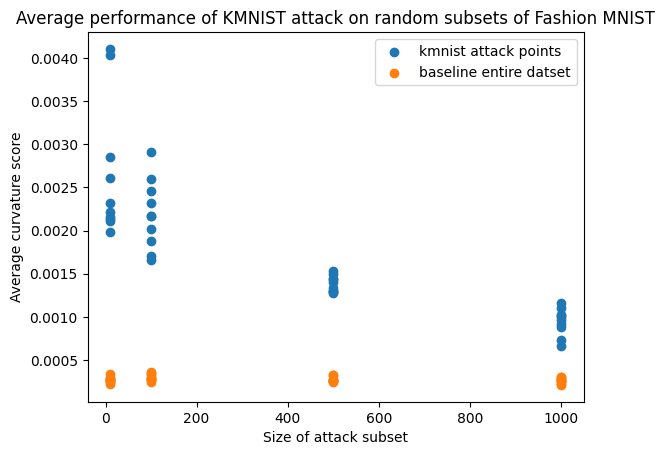

In [40]:
plt.scatter(random_averages[0, :], random_averages[1, :], label='kmnist attack points')
plt.scatter(random_averages[0, :], random_averages[2, :], label='baseline entire datset')
plt.title('Average performance of KMNIST attack on random subsets of Fashion MNIST')
plt.xlabel('Size of attack subset')
plt.ylabel('Average curvature score')
plt.legend()
plt.show()

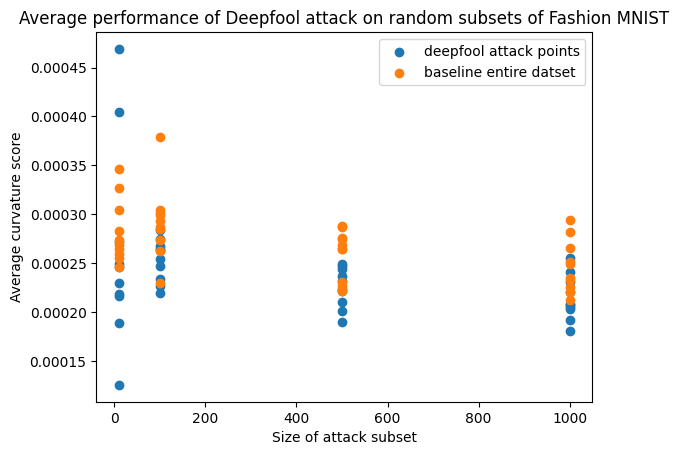

In [41]:
plt.scatter(deepfool_averages[0, :], deepfool_averages[1, :], label='deepfool attack points')
plt.scatter(deepfool_averages[0, :], deepfool_averages[2, :], label='baseline entire datset')
plt.title('Average performance of Deepfool attack on random subsets of Fashion MNIST')
plt.xlabel('Size of attack subset')
plt.ylabel('Average curvature score')
plt.legend()
plt.show()

In [42]:
sizes = [10, 100, 500, 1000]
random_attack_averages = np.concat([get_triple_from_path(f'{SCORE_DIR}/random_{size}_attack', size) for size in sizes], axis=1)
deepfool_attack_averages = np.concat([get_triple_from_path(f'{SCORE_DIR}/deepfool_{size}_overshoot_02_attack', size) for size in sizes], axis=1)

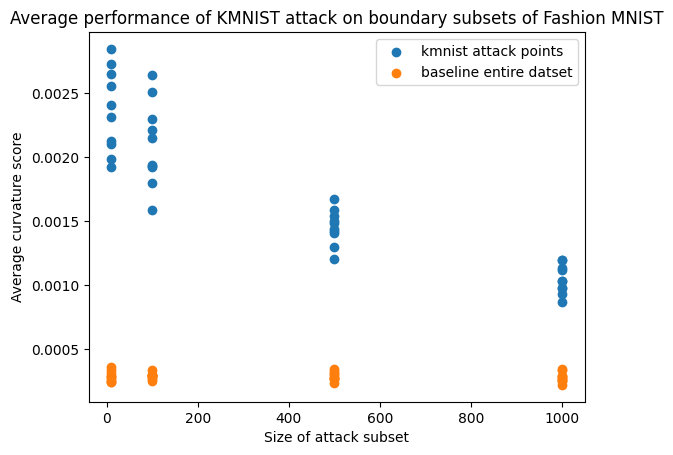

In [43]:
plt.scatter(random_attack_averages[0, :], random_attack_averages[1, :], label='kmnist attack points')
plt.scatter(random_attack_averages[0, :], random_attack_averages[2, :], label='baseline entire datset')
plt.title('Average performance of KMNIST attack on boundary subsets of Fashion MNIST')
plt.xlabel('Size of attack subset')
plt.ylabel('Average curvature score')
plt.legend()
plt.show()

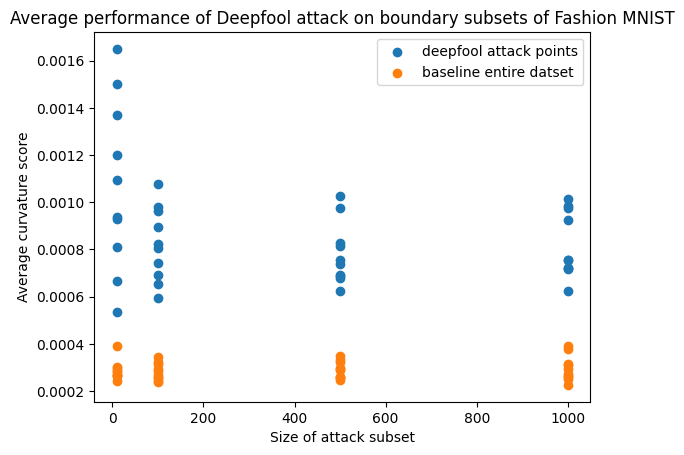

In [44]:
plt.scatter(deepfool_attack_averages[0, :], deepfool_attack_averages[1, :], label='deepfool attack points')
plt.scatter(deepfool_attack_averages[0, :], deepfool_attack_averages[2, :], label='baseline entire datset')
plt.title('Average performance of Deepfool attack on boundary subsets of Fashion MNIST')
plt.xlabel('Size of attack subset')
plt.ylabel('Average curvature score')
plt.legend()
plt.show()

In [49]:
def load_compare_df(size):
    total_dict = dict()
    for i in range(10):
        random_dict = np.load(f'{SCORE_DIR}/random_{size}_attack/run_{i+1}.npz')
        subset, random_scores = random_dict['subset'], random_dict['scores']
        fool_dict = np.load(f'{SCORE_DIR}/deepfool_{size}_overshoot_02_attack/run_{i+1}.npz')
        fool_scores = fool_dict['scores']
        total_dict[f'idxs {i+1}'] = subset
        total_dict[f'kmnist {i+1}'] = random_scores[subset]
        total_dict[f'deepfool {i+1}'] = fool_scores[subset]
    return pd.DataFrame(total_dict)

In [51]:
compare_df = load_compare_df(10)

In [58]:
def get_side_by_side_df(size):
    compare_df = load_compare_df(size)
    kmnists = pd.concat([compare_df[f'kmnist {i+1}'] for i in range(10)])
    deepfools = pd.concat([compare_df[f'deepfool {i+1}'] for i in range(10)])
    return pd.DataFrame({'kmnists': kmnists, 'deepfools': deepfools})

In [61]:
side_by_side_10 = get_side_by_side_df(10)

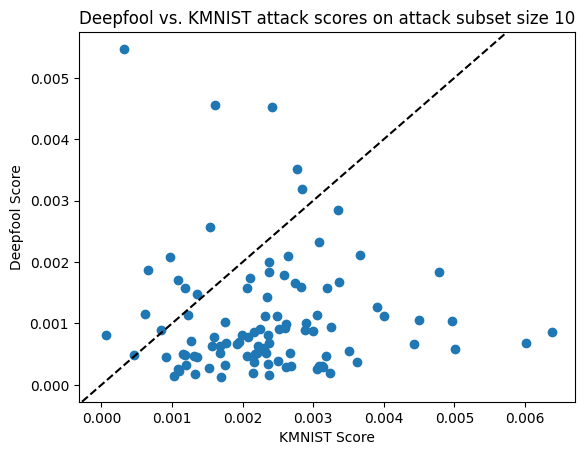

In [66]:
fig, ax = plt.subplots()
ax.scatter(side_by_side_10['kmnists'], side_by_side_10['deepfools'])
ax.axline((0,0), slope=1, linestyle='--', label='baseline', color='black')
ax.set_title('Deepfool vs. KMNIST attack scores on attack subset size 10')
ax.set_xlabel('KMNIST Score')
ax.set_ylabel('Deepfool Score')
plt.show()

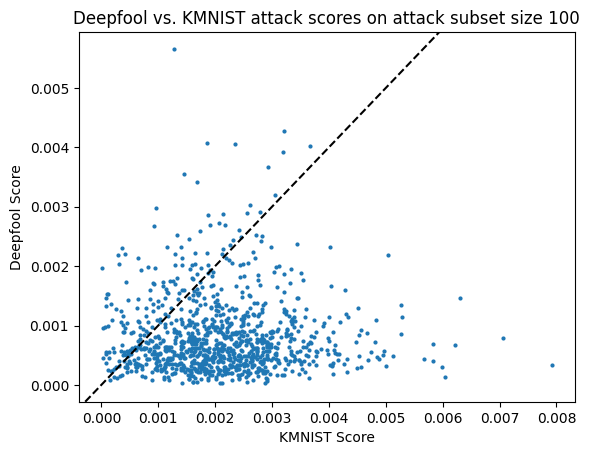

In [69]:
side_by_side_100 = get_side_by_side_df(100)
fig, ax = plt.subplots()
ax.scatter(side_by_side_100['kmnists'], side_by_side_100['deepfools'], s=4)
ax.axline((0,0), slope=1, linestyle='--', label='baseline', color='black')
ax.set_title('Deepfool vs. KMNIST attack scores on attack subset size 100')
ax.set_xlabel('KMNIST Score')
ax.set_ylabel('Deepfool Score')
plt.show()

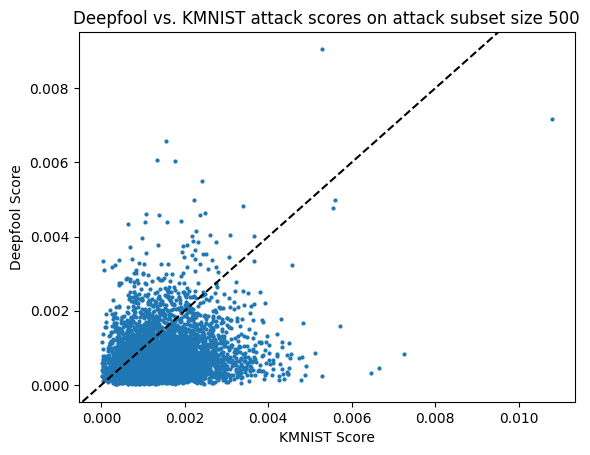

In [70]:
side_by_side_500 = get_side_by_side_df(500)
fig, ax = plt.subplots()
ax.scatter(side_by_side_500['kmnists'], side_by_side_500['deepfools'], s=4)
ax.axline((0,0), slope=1, linestyle='--', label='baseline', color='black')
ax.set_title('Deepfool vs. KMNIST attack scores on attack subset size 500')
ax.set_xlabel('KMNIST Score')
ax.set_ylabel('Deepfool Score')
plt.show()

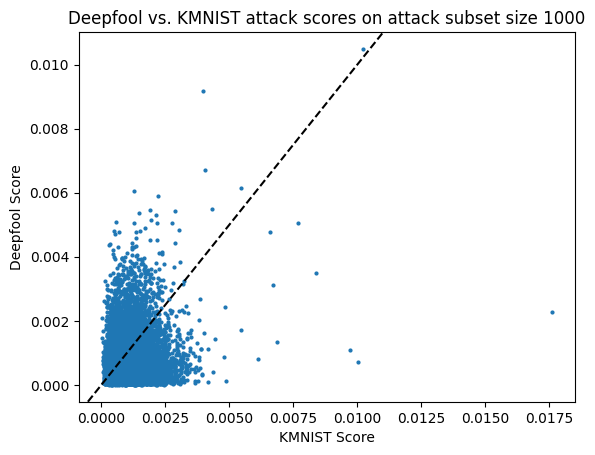

In [71]:
side_by_side_1000 = get_side_by_side_df(1000)
fig, ax = plt.subplots()
ax.scatter(side_by_side_1000['kmnists'], side_by_side_1000['deepfools'], s=4)
ax.axline((0,0), slope=1, linestyle='--', label='baseline', color='black')
ax.set_title('Deepfool vs. KMNIST attack scores on attack subset size 1000')
ax.set_xlabel('KMNIST Score')
ax.set_ylabel('Deepfool Score')
plt.show()

In [22]:
sizes = [10, 100, 500, 1000]
quads = pd.DataFrame()
for size in sizes:
    subset_size, subset_avg, base_avg = get_triple_from_path(f'{SCORE_DIR}/random_{size}', size)
    quads = pd.concat((quads, pd.DataFrame([np.array(['kmnist'] * 10), subset_size, subset_avg, base_avg, np.array(['random'] * 10)]).T))
for size in sizes:
    subset_size, subset_avg, base_avg = get_triple_from_path(f'{SCORE_DIR}/random_{size}_attack', size)
    quads = pd.concat((quads, pd.DataFrame([np.array(['kmnist'] * 10), subset_size, subset_avg, base_avg, np.array(['boundary'] * 10)]).T))
for size in sizes:
    subset_size, subset_avg, base_avg = get_triple_from_path(f'{SCORE_DIR}/deepfool_{size}_overshoot_02', size)
    quads = pd.concat((quads, pd.DataFrame([np.array(['deeofool'] * 10), subset_size, subset_avg, base_avg, np.array(['random'] * 10)]).T))
for size in sizes:
    subset_size, subset_avg, base_avg = get_triple_from_path(f'{SCORE_DIR}/deepfool_{size}_overshoot_02_attack', size)
    quads = pd.concat((quads, pd.DataFrame([np.array(['deepfool'] * 10), subset_size, subset_avg, base_avg, np.array(['boundary'] * 10)]).T))
quads = quads.rename(columns={0: 'attack type', 1: 'subset size', 2: 'subset average', 3: 'dataset average', 4: 'attack points'})
quads

,attack type,subset size,subset average,dataset average,attack points
0,kmnist,10.0,0.002221,0.000219,random
1,kmnist,10.0,0.002114,0.000284,random
2,kmnist,10.0,0.002129,0.00027,random
3,kmnist,10.0,0.001989,0.000266,random
4,kmnist,10.0,0.002858,0.000294,random
...,...,...,...,...,...
5,deepfool,1000.0,0.000718,0.000293,boundary
6,deepfool,1000.0,0.000925,0.000312,boundary
7,deepfool,1000.0,0.000756,0.000313,boundary
8,deepfool,1000.0,0.000624,0.000265,boundary


In [24]:
quads.to_csv('quads.csv')

In [30]:
sizes = [10, 100, 500, 1000]
attack_types = []
subset_sizes = []
subset_avgs = []
base_avgs = []
attack_points = []
for size in sizes:
    subset_size, subset_avg, base_avg = get_triple_from_path(f'{SCORE_DIR}/random_{size}', size)
    attack_types.append(['kmnist']), subset_sizes.append(size), subset_avgs.append(np.mean(subset_avg)), base_avgs.append(np.mean(base_avg)), attack_points.append('random')
for size in sizes:
    subset_size, subset_avg, base_avg = get_triple_from_path(f'{SCORE_DIR}/random_{size}_attack', size)
    attack_types.append(['kmnist']), subset_sizes.append(size), subset_avgs.append(np.mean(subset_avg)), base_avgs.append(np.mean(base_avg)), attack_points.append('boundary')
for size in sizes:
    subset_size, subset_avg, base_avg = get_triple_from_path(f'{SCORE_DIR}/deepfool_{size}_overshoot_02', size)
    attack_types.append(['deepfool']), subset_sizes.append(size), subset_avgs.append(np.mean(subset_avg)), base_avgs.append(np.mean(base_avg)), attack_points.append('random')
for size in sizes:
    subset_size, subset_avg, base_avg = get_triple_from_path(f'{SCORE_DIR}/deepfool_{size}_overshoot_02_attack', size)
    attack_types.append(['deepfool']), subset_sizes.append(size), subset_avgs.append(np.mean(subset_avg)), base_avgs.append(np.mean(base_avg)), attack_points.append('boundary')
quads_avgs = pd.DataFrame({
    'attack type': attack_types,
    'subset size': subset_sizes,
    'subset average': subset_avgs,
    'dataset average': base_avgs,
    'attack points': attack_points
})
quads_avgs

,attack type,subset size,subset average,dataset average,attack points
0,[kmnist],10,0.002655,0.000272,random
1,[kmnist],100,0.002189,0.000298,random
2,[kmnist],500,0.001380,0.000272,random
3,[kmnist],1000,0.000946,0.000259,random
4,[kmnist],10,0.002364,0.000287,boundary
5,[kmnist],100,0.002099,0.000290,boundary
6,[kmnist],500,0.001456,0.000289,boundary
7,[kmnist],1000,0.001045,0.000280,boundary
8,[deepfool],10,0.000262,0.000283,random
9,[deepfool],100,0.000253,0.000291,random


In [31]:
quads_avgs.to_csv('quads_avgs.csv')

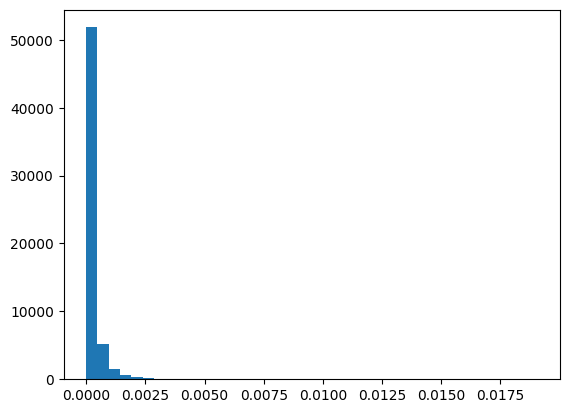

In [37]:
plt.hist(load_scores_for_dir(f'{SCORE_DIR}/random_10')[1], bins=40)
plt.show()